# Isodensity lines in R and $\rho$

Plot isodensity lines. Optionally, you can tune a median filter to remove fast fluctuations in density.

This notebook runs in autopilot, meaning you can control everything by changing a few parameters. Look for the indication **<span style="color:blue">parameters</span>** to find them. Every cell contains a brief description at the top.

Refer to notebook 15A for ELM-free isodensity lines.

#### Import libraries

In [1]:
%matplotlib notebook
from __future__ import print_function
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
import matplotlib.pyplot as plt
from ipfnpytools.plot import plots
from ipfnpytools.plot import plot_signals
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
import reflectometry as rfl
from scipy.signal import medfilt
from ipfnpytools.trz_to_rhop import fast_trz_to_rhop
from ipfnpytools.trhoptheta_to_rz import trhoptheta_to_rz
from ipfnpytools.trhopz_to_r import trhopz_to_r 
import matplotlib.patheffects as pe
import os
from ipfnpytools.current_flattop import current_flattop
from ipfnpytools.rhosep2 import rhosep2
import map_equ
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### <span style="color:blue">Parameters: Data Fetching</span>

In [2]:
# Shot number
shot = 36792

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# If chosen source == 'dump', state the relative path
path = "../../lab_rot/phd_part08_faitch_initializations/RPS_dump_xhfs_2sep-0m050.37765"

# Magnetic equillibrium "EQH" or "IDE"
equillibrium = "EQH"

Fetch all the necessary data to plot the isodensity lines and performe certain preprocessing tasks such as $\rho$ poloidal mapping

In [3]:
# Determine the plasma current flat top window --------------------

[t0, t1] = current_flattop(shot)

# Fetch reflectometry data ----------------------------------------

time, lfs_signal, hfs_signal, lfs_area, hfs_area, _, _ = rfl.fetch(shot, path if source=='dump' else None, verbose=True)
density = lfs_signal[0,:]

# Fetch rho vs. time for the secondary separatrix -----------------

parameters = 'IDG' if equillibrium == 'IDE' else 'GQH'
sep2_time, sep2_data = rhosep2(shot, equil=parameters) 

# Open and prepare the equilibrium shotfile -----------------------

eq = map_equ.equ_map()
eq.Open(shot, equillibrium)
#Populate the fields
eq.read_pfm()
eq.read_scalars()

# Map secondary separatrix in R[m] at antenna height --------------

zl = 0.14  # Antenna height on LFS
zh = 0.07  # Antenna height on HFS

r_sep2_hfs, _ = trhopz_to_r(sep2_time, sep2_data, zh*np.ones_like(sep2_time), eq_shotfile=eq)
_, r_sep2_lfs = trhopz_to_r(sep2_time, sep2_data, zl*np.ones_like(sep2_time), eq_shotfile=eq)

# Map primary separatrix (rho=1) in R[m] at the antenna height ---

r_sep1_hfs, _ = trhopz_to_r(sep2_time, np.ones_like(sep2_time), zh*np.ones_like(sep2_time), eq_shotfile=eq)
_, r_sep1_lfs = trhopz_to_r(sep2_time, np.ones_like(sep2_time), zl*np.ones_like(sep2_time), eq_shotfile=eq)

# Map inner and outer wall at antenna height to rho poloidal ------

inner_wall = 1.045
outer_wall = 2.22

# inner_wall_rho = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), np.ones_like(lfs_area)*inner_wall, np.ones_like(lfs_area)*zh, shot, equillibrium=equillibrium, eq_shotfile=eq)
# outer_wall_rho = fast_trz_to_rhop(np.atleast_2d(time).T * np.ones(lfs_area.shape[1]), np.ones_like(lfs_area)*outer_wall, np.ones_like(lfs_area)*zl, shot, equillibrium=equillibrium, eq_shotfile=eq)

# Map reflectomety density profiles to rho poloidal ---------------

rhol = fast_trz_to_rhop(time[:, None], lfs_area, zl, eq_shotfile=eq)
rhoh = fast_trz_to_rhop(time[:, None], hfs_area, zh, eq_shotfile=eq)

('time:', (23951,))
('lfs_signal:', (23951, 151))
('lfs_area:', (23951, 151))
('lfs_gd:', (23951, 151))
('hfs_signal:', (23951, 151))
('hfs_area:', (23951, 151))
('hfs_gd:', (23951, 151))


### <span style="color:blue">Parameters: Post Processing</span>

In [4]:
# Post processing options -------------------------------------------

rfl_median_points = 11   # Median filter number of points 
                        # (choose n=1 for no filtering)
mag_median_points = 3   # Median filter number of points 
                        # (choose n=1 for no filtering)
    
# Information regarding post processing options ---------------------

print("Applying median filtering with %d points to reflectometry signals" % rfl_median_points)
print("Applying median filtering with %d points to magnetic signals" % mag_median_points)
print("Reflectometry data: %d points corresponds to a %.3lf ms window" % (rfl_median_points, 1e3*(time[rfl_median_points] - time[0])))
print("Magnetic data: %d points corresponds to a %.3lf ms window" % (mag_median_points, 1e3*(sep2_time[mag_median_points] - sep2_time[0])))

median_lfs_area = medfilt(lfs_area, (rfl_median_points, 1))
median_hfs_area = medfilt(hfs_area, (rfl_median_points, 1))

median_rhol = medfilt(rhol, (rfl_median_points, 1))
median_rhoh = medfilt(rhoh, (rfl_median_points, 1))

Applying median filtering with 11 points to reflectometry signals
Applying median filtering with 3 points to magnetic signals
Reflectometry data: 11 points corresponds to a 1.540 ms window
Magnetic data: 3 points corresponds to a 7.000 ms window


### <span style="color:blue">Parameters: Data Visualization</span>

In [5]:
# Isodensity options ------------------------------------------------

n_iso = 10  # Number of isodensity lines displayed
start_density = 3e18  # First isodensity
stop_density = 3.0e19  # Last isodensity

# General plot options ----------------------------------------------

fig_size = (16, 9)  # Figure size (inches)

### <span style="color:blue">Parameters: Post Processing</span>
# Isodensity advanced options, choose 1 or 2 -----------------------

option = 2

# 1 - Guarantees uniform spacing between isodensity lines,
#     but does not guarantee inclusion of the last isodensity chosen.

# 2 - Guarantees inclusion of the last isodensity line,
#     but does not guarantee uniform spacing between each line.

The next cell applies the vizualization parameters and provides some general feedback regarding the user options

In [6]:
# Information regarding the isodensity lines displayed --------------

last_index = closest(density, stop_density)
first_index = closest(density, start_density)

if (last_index - first_index + 1) < n_iso:
    print("Impossible drawing " + str(n_iso) + " isodensities, drawing only " + str(last_index - first_index + 1))
    n_iso = last_index - first_index + 1
    
if option == 1:
    drawing_indexes = np.unique(range(first_index, last_index + 1, (last_index - first_index + 1)/n_iso))
elif option == 2:
    drawing_indexes = np.unique(np.rint(np.linspace(first_index, last_index, n_iso)).astype(np.int))
    
print("Selected isodensities:", [density[i] for i in drawing_indexes])

Selected isodensities: [2.980164e+18, 4.477999e+18, 6.5619426e+18, 8.7110095e+18, 1.153922e+19, 1.4339518e+19, 1.7911995e+19, 2.1363529e+19, 2.5680266e+19, 2.9783034e+19]


### Plot isodensities in R \[m\] vs. time \[s\]

<IPython.core.display.Javascript object>


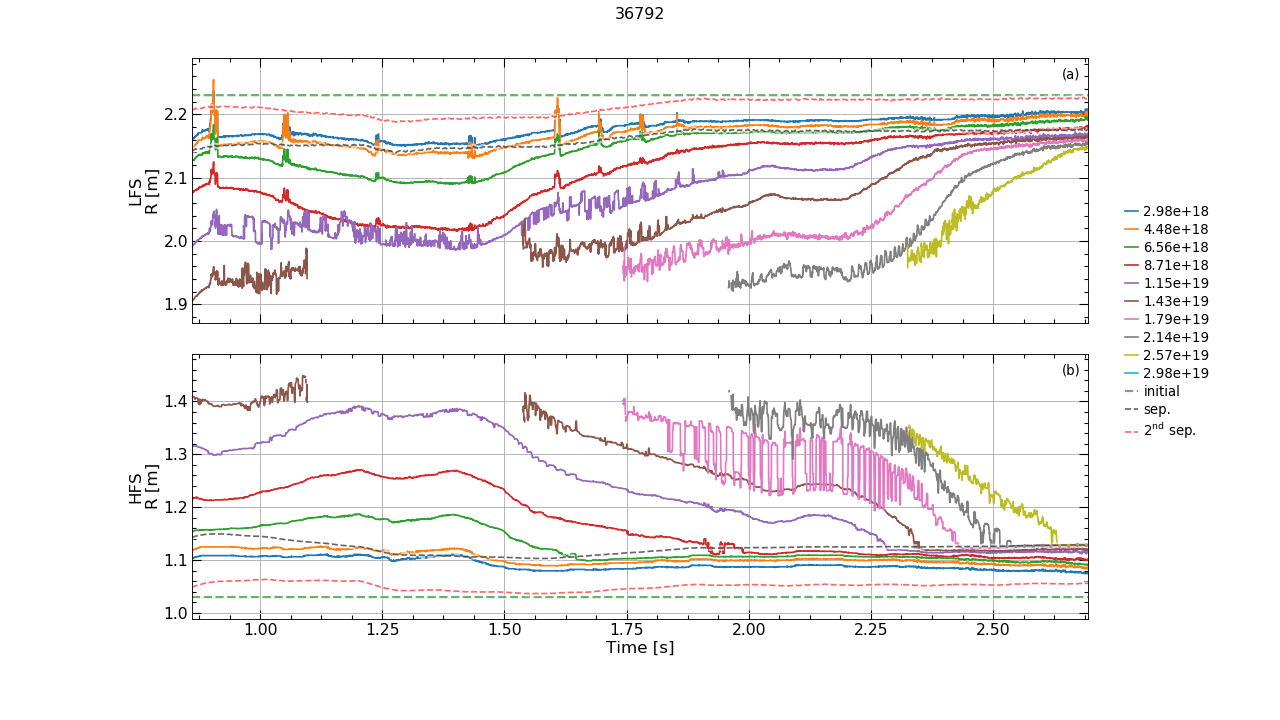

In [7]:
fig, axes = plots(
    figsize=fig_size,
    x=time, 
    y=[median_lfs_area.T[i] for i in drawing_indexes] + \
      [median_hfs_area.T[i] for i in drawing_indexes],
    boxes=[0]*n_iso + [1]*n_iso, 
    labels=["%.2e" % density[i] for i in drawing_indexes] + [None]*len(drawing_indexes),
    legend_kw={'loc':'center left', 'bbox_to_anchor':[1.02,-1,0.3,2]},
    y_mins=[None]*n_iso + [None]*n_iso,
    y_maxs=[None]*n_iso + [None]*n_iso,
#     x_mins=t0,
#     x_maxs=t1,
    sharex=True,
    y_labels=["LFS\nR [m]", "HFS\nR [m]"],
    x_labels=["", "Time [s]"],
    title=str(shot)
)

# axes[0].plot(-10, 0, color='green', linestyle='--', lw=3, label='initial', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[0].plot(time, lfs_area.T[0], color='green', linestyle='--', lw=2, label='initial', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(time, hfs_area.T[0], color='green', linestyle='--', lw=2, alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
# axes[0].legend(loc='center left', bbox_to_anchor=[1.02,-1,0.3,2], frameon=False);
# plt.tight_layout()

axes[0].plot(sep2_time, medfilt(r_sep1_lfs, mag_median_points), color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(sep2_time, medfilt(r_sep1_hfs, mag_median_points), color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].plot(sep2_time, medfilt(r_sep2_lfs, mag_median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(sep2_time, medfilt(r_sep2_hfs, mag_median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].legend(loc='center left', bbox_to_anchor=[1.02,-1,0.3,2], frameon=False);

axes[0].set_xlim((t0, t1))
# axes[0].set_xlim((1.5, 4.5))

rfl.autoscale(axes[0], margin=0.1)
rfl.autoscale(axes[1], margin=0.1)

### <span style="color:blue">Parameters</span>
Change the figure manualy with your cursor, or by running the following cell. To uncomment a given line, place your caret on the line and press `Ctrl`+`~`

In [8]:
# fig.set_size_inches(11, 4)  # Figure size in inches (width, height)

# axes[0].set_ylim(2.0, 2.25)  # LFS range in R [m]
# axes[1].set_ylim(1.03, 1.15) # HFS range in R [m]

# axes[0].set_xlim(2.225, 2.260); # Time range [s]
# axes[1].set_xlim(2.25, 4.25); # Time range [s]

# rfl.autoscale(axes[0], margin=0.1)  # Autoscale in LFS in R[m] 
#                                     # once you have chosen the time window                  
# rfl.autoscale(axes[1], margin=0.1)  # Same for the HFS

### Save the figure to your working directory

In [9]:
# target_dir = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d" % shot
# file_name = "%d_isodensity_R" % shot

# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)

# save_figure(fig, target_dir + "/" + file_name)

### Plot isodensities in $\rho$ poloidal vs. time \[s\]

<IPython.core.display.Javascript object>


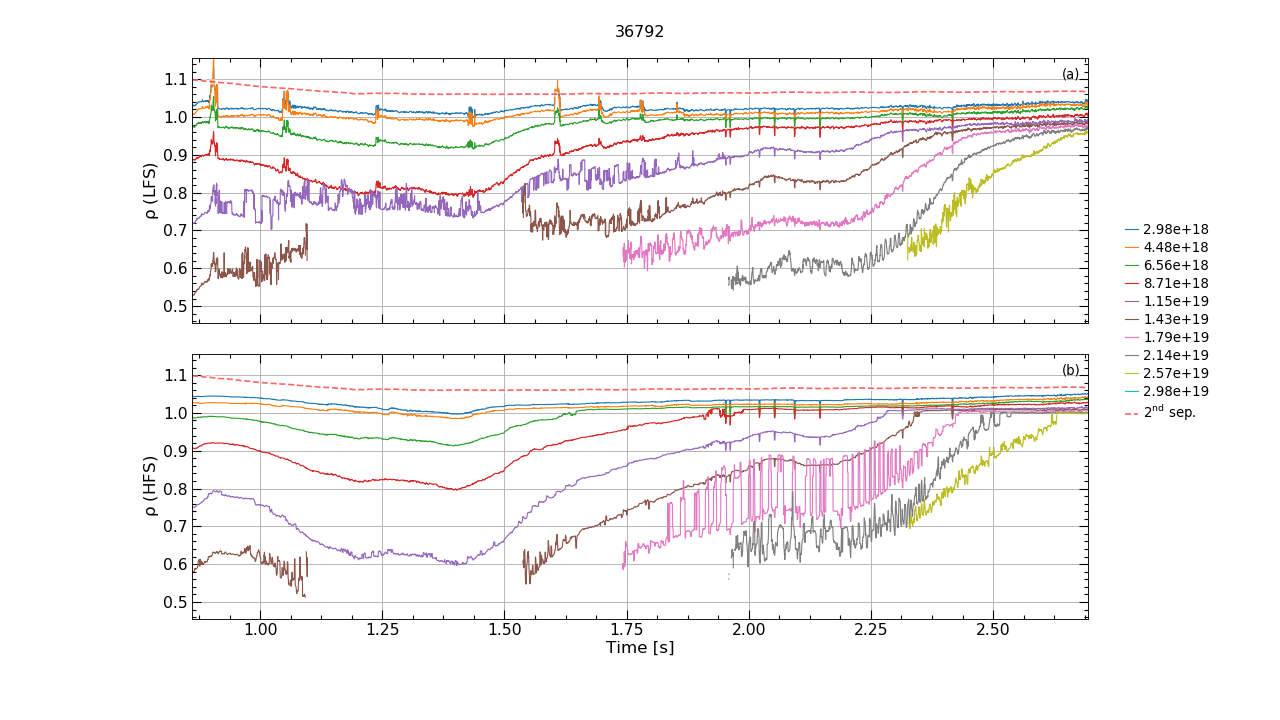

In [10]:
rhol[rhol == 0.0] = np.nan 
rhoh[rhoh == 0.0] = np.nan 

fig2, axes2 = plots(
    x=time, y=[median_rhol.T[i] for i in drawing_indexes] + [median_rhoh.T[i] for i in drawing_indexes], 
    boxes=[0]*n_iso + [1]*n_iso, 
    labels=["%.2e" % density[i] for i in drawing_indexes] + [None]*len(drawing_indexes),
    legend_kw={'loc':'center left', 'bbox_to_anchor':[1.02,-1,0.3,2]},
    y_mins=[None]*n_iso + [None]*n_iso,
    y_maxs=[None]*n_iso + [None]*n_iso,
    x_mins=t0,
    x_maxs=t1,
    sharex=True,
    sharey=True,
    y_labels=[r"$\rho$ (LFS)", r"$\rho$ (HFS)"],
    title=str(shot),
    linewidths=1,
)
fig2.set_size_inches(*fig_size)
# plt.tight_layout()
# plt.xlim((2, 8))
plt.xlabel("Time [s]")

# axes[0].plot(raus.time, raus.data, color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
# axes[1].plot(rin.time, rin.data, color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes2[0].plot(sep2_time, medfilt(sep2_data, mag_median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes2[1].plot(sep2_time, medfilt(sep2_data, mag_median_points), color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes2[0].legend(loc='center left', bbox_to_anchor=[1.02,-1,0.3,2], frameon=False);

axes2[0].set_xlim((t0, t1))
# axes2[0].set_xlim((1.5, 4.5))
rfl.autoscale(axes2[0], margin=0.1)
rfl.autoscale(axes2[1], margin=0.1)

### <span style="color:blue">Parameters</span>
Change the figure manualy with your cursor, or by running the following cell. To uncomment a given line, place your caret on the line and press `Ctrl`+`~`

In [11]:
# fig2.set_size_inches(11, 3.5)  # Figure size in inches (width, height)
# axes2[1].set_ylim(0.8, 1.2) # rho poloidal
# axes2[0].set_ylim(0.8, 1.2) # rho poloidal
# axes2[1].set_xlim((4, 6))      # Time[s]


### Save the figure to your working directory

In [12]:
# target_dir = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d" % shot
# file_name = "%d_isodensity_rho" % shot

# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)

# save_figure(fig, target_dir + "/" + file_name)